In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

In [ ]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
### YOUR CODE HERE
# Figure out how to import regularizers
###
import tensorflow.keras.utils as ku 
import numpy as np 

In [ ]:
tokenizer = Tokenizer()
!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/sonnets.txt \
    -O /tmp/sonnets.txt
data = open('/tmp/sonnets.txt').read()

corpus = data.lower().split("\n")


tokenizer.fit_on_texts(corpus)
total_words = len(tokenizer.word_index) + 1

# create input sequences using list of tokens
input_sequences = []
for line in corpus:
	token_list = tokenizer.texts_to_sequences([line])[0]
	for i in range(1, len(token_list)):
		n_gram_sequence = token_list[:i+1]
		input_sequences.append(n_gram_sequence)


# pad sequences 
max_sequence_len = max([len(x) for x in input_sequences])
input_sequences = np.array(pad_sequences(input_sequences, maxlen=max_sequence_len, padding='pre'))

# create predictors and label
predictors, label = input_sequences[:,:-1],input_sequences[:,-1]

label = ku.to_categorical(label, num_classes=total_words)

In [ ]:
model = Sequential()
model.add(# Your Embedding Layer)
model.add(# An LSTM Layer)
model.add(# A dropout layer)
model.add(# Another LSTM Layer)
model.add(# A Dense Layer including regularizers)
model.add(# A Dense Layer)
# Pick an optimizer
model.compile(# Pick a loss function and an optimizer)
print(model.summary())


In [ ]:
 history = model.fit(predictors, label, epochs=100, verbose=1)

In [ ]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
loss = history.history['loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training accuracy')
plt.title('Training accuracy')

plt.figure()

plt.plot(epochs, loss, 'b', label='Training Loss')
plt.title('Training loss')
plt.legend()

plt.show()

In [ ]:
seed_text = "Help me Obi Wan Kenobi, you're my only hope"
next_words = 100
  
for _ in range(next_words):
	token_list = tokenizer.texts_to_sequences([seed_text])[0]
	token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')
	predicted = model.predict_classes(token_list, verbose=0)
	output_word = ""
	for word, index in tokenizer.word_index.items():
		if index == predicted:
			output_word = word
			break
	seed_text += " " + output_word
print(seed_text)

## 실습 코드

In [51]:
import tensorflow as tf
from tensorflow.keras.layers import Embedding, LSTM, Dropout, Dense, Flatten, Conv1D
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import Adam, RMSprop

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

import os

In [9]:
# Data load by https://storage.googleapis.com/laurencemoroney-blog.appspot.com/sonnets.txt
!wget https://storage.googleapis.com/laurencemoroney-blog.appspot.com/sonnets.txt -O /tmp/sonnets.txt

--2021-01-26 01:19:19--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/sonnets.txt
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.9.208, 172.217.12.240, 172.253.122.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.9.208|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 93578 (91K) [text/plain]
Saving to: ‘/tmp/sonnets.txt’

/tmp/sonnets.txt    100%[===================>]  91.38K  --.-KB/s    in 0.001s  

2021-01-26 01:19:19 (153 MB/s) - ‘/tmp/sonnets.txt’ saved [93578/93578]



In [19]:
# Read txt file
data = open('/tmp/sonnets.txt', 'r')
data = data.read()

# lower 
corpus = data.lower().split('\n')

In [25]:
# Make Tokenizer
tokenizer = Tokenizer()
tokenizer.fit_on_texts(corpus)
total_words = len(tokenizer.word_index)+ 1 # number of words
print(total_words)

3211


In [72]:
# Make Sequences
sequences = tokenizer.texts_to_sequences(corpus)

In [73]:
# Make training sequences
# [1, 2], [1,2, 3], [1, 2, 3, 4]
input_sequences = list()

for line in sequences:
  for i in range(1, len(line)):
    n_gram_sequence = line[: i+1]
    input_sequences.append(n_gram_sequence)

In [74]:
# Hyper parameters 
padding_type = 'pre'
trunc_type = 'post'
max_sequences_len = max(map(len, input_sequences))
print(max_sequences_len)

11


In [75]:
# Add padding
padded = pad_sequences(input_sequences, maxlen=max_sequences_len, padding=padding_type, truncating=trunc_type)

In [76]:
# Create train and labels
predictors = padded[:, :-1]
labels = padded[:, -1]

# categorical
labels = to_categorical(labels, num_classes=total_words)
print(predictors[:3], labels[0])

[[  0   0   0   0   0   0   0   0   0  34]
 [  0   0   0   0   0   0   0   0  34 417]
 [  0   0   0   0   0   0   0  34 417 877]] [0. 0. 0. ... 0. 0. 0.]


In [77]:
# Make model
model = tf.keras.Sequential([
                             Embedding(input_dim=total_words, output_dim=128, input_length=max_sequences_len-1),
                             tf.keras.layers.Bidirectional(LSTM(256, return_sequences=True)),
                             Dropout(0.2),
                             tf.keras.layers.Bidirectional(LSTM(128, return_sequences=True)),
                             Conv1D(128, 5, activation='relu'),
                             Flatten(),
                             Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.003)),
                             Dropout(0.2),
                             Dense(total_words, activation='softmax')
])

model.compile(loss='categorical_crossentropy', optimizer=Adam(0.003), metrics=['accuracy'])
model.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_9 (Embedding)      (None, 10, 128)           411008    
_________________________________________________________________
bidirectional_18 (Bidirectio (None, 10, 512)           788480    
_________________________________________________________________
dropout_18 (Dropout)         (None, 10, 512)           0         
_________________________________________________________________
bidirectional_19 (Bidirectio (None, 10, 256)           656384    
_________________________________________________________________
conv1d_9 (Conv1D)            (None, 6, 128)            163968    
_________________________________________________________________
flatten_9 (Flatten)          (None, 768)               0         
_________________________________________________________________
dense_18 (Dense)             (None, 512)              

In [80]:
history = model.fit(predictors, labels, batch_size=32, epochs=50, verbose=1)

Epoch 1/50
484/484 [==============================] - 7s 13ms/step - loss: 6.6230 - accuracy: 0.0239
Epoch 2/50
484/484 [==============================] - 6s 13ms/step - loss: 6.4366 - accuracy: 0.0319
Epoch 3/50
484/484 [==============================] - 6s 13ms/step - loss: 6.2742 - accuracy: 0.0367
Epoch 4/50
484/484 [==============================] - 6s 13ms/step - loss: 6.1219 - accuracy: 0.0409
Epoch 5/50
484/484 [==============================] - 6s 13ms/step - loss: 5.9720 - accuracy: 0.0500
Epoch 6/50
484/484 [==============================] - 6s 13ms/step - loss: 5.8420 - accuracy: 0.0540
Epoch 7/50
484/484 [==============================] - 6s 13ms/step - loss: 5.6982 - accuracy: 0.0589
Epoch 8/50
484/484 [==============================] - 6s 13ms/step - loss: 5.5722 - accuracy: 0.0653
Epoch 9/50
484/484 [==============================] - 6s 13ms/step - loss: 5.4437 - accuracy: 0.0732
Epoch 10/50
484/484 [==============================] - 6s 13ms/step - loss: 5.3164 - accura

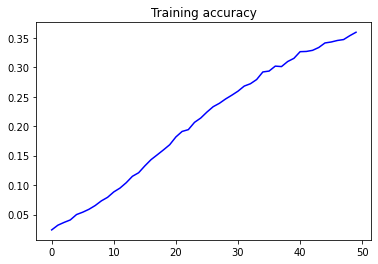

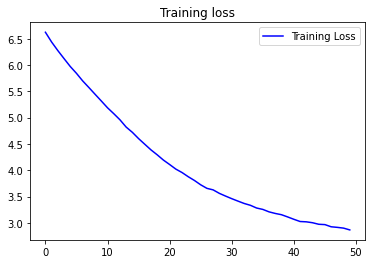

In [92]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
loss = history.history['loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training accuracy')
plt.title('Training accuracy')

plt.figure()

plt.plot(epochs, loss, 'b', label='Training Loss')
plt.title('Training loss')
plt.legend()

plt.show()

In [93]:
# Create new sentences

In [127]:
seed_text = "Help me Obi Wan Kenobi, you're my only hope"
next_words = 50
reverse_word_index = dict((value, key) for (key, value) in tokenizer.word_index.items())

for i in range(next_words):
  token_list = tokenizer.texts_to_sequences([seed_text])
  token_list = pad_sequences(token_list, maxlen=max_sequences_len-1)
  next_words = model.predict_classes(token_list)
  try:
    seed_text += " " + reverse_word_index[next_words[0]]
  except KeyError as key:
    pass

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


In [128]:
seed_text

"Help me Obi Wan Kenobi, you're my only hope quite ride hour doth hide his skill up you must rare old deceive exceeds dead exceeds more remember all too chest give praise away something new to thee i died before straight than blind wrong ' must dead afloat appear hide my love up all things pride of him i"